In [2]:
from chembl_webresource_client.new_client import new_client
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors

/home/sharens/projects/python/ml_deepchem/.venv/lib/python3.12/site-packages/chembl_webresource_client/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('chembl_webresource_client').version


In [3]:
def fetch_chembl_activity_to_polars(target_id="CHEMBL203", activity_type="IC50"):
    activity = new_client.activity
    query = activity.filter(target_chembl_id=target_id).filter(standard_type=activity_type)
    
    print(f"Pobieranie danych dla celu: {target_id}...")
    data = list(query)

    if data:
        df = pl.DataFrame(data, infer_schema_length=None)
        
        # Konwersja standard_value na float (jeśli istnieje)
        if "standard_value" in df.columns:
             df = df.with_columns(
                pl.col("standard_value").cast(pl.Float64, strict=False)
            )
        
        return df
    else:
        print("Nie znaleziono danych.")
        return pl.DataFrame()

# Uruchomienie
df_activity = fetch_chembl_activity_to_polars()


Pobieranie danych dla celu: CHEMBL203...


In [4]:
# 1. Ustawienie konfiguracji (globalnie dla sesji)
pl.Config.set_tbl_cols(50)       # Pokazuj do 50 kolumn
pl.Config.set_tbl_width_chars(2000) # Zwiększ szerokość wyświetlania w konsoli

# 2. Wyświetlenie DataFrame
print(f"Pobrano {len(df_activity)} wierszy.")
print(df_activity.head())

Pobrano 25758 wierszy.
shape: (5, 46)
┌─────────────┬──────────────────┬─────────────┬─────────────────────┬─────────────────┬─────────────────────────────────┬────────────┬─────────────────────────┬────────────────────────┬──────────────┬─────────────┬───────────────────────┬─────────────────────────────────┬───────────────────────┬───────────────────────────┬────────────────────┬──────────────────────┬───────────────┬────────────────────────────────┬────────────────────┬────────────────────┬───────────────────────────┬───────────────┬─────────────────────┬─────────────────────────────────┬───────────┬──────────┬────────┬───────────────┬───────────────────┬─────────────────────┬───────────────┬────────────────┬──────────────────────┬────────────────┬──────────────────┬─────────────────┬─────────────────────────────────┬───────────────┬────────────┬──────┬──────┬───────┬────────────┬─────────────┬───────┐
│ action_type ┆ activity_comment ┆ activity_id ┆ activity_properties ┆ assay_chem

Dane na temat nulli w kolumnach:
shape: (1, 46)
┌─────────────┬──────────────────┬─────────────┬─────────────────────┬─────────────────┬───────────────────┬────────────┬─────────────────────────┬────────────────────────┬──────────────┬────────────┬───────────┬──────────────────┬───────────────────────┬───────────────────────────┬────────────────────┬──────────────────┬───────────────┬───────────────────┬────────────────────┬────────────────────┬───────────────────────────┬───────────────┬─────────────────────┬────────────┬───────────┬──────────┬────────┬───────────────┬───────────────────┬─────────────────────┬───────────────┬────────────────┬──────────────────────┬────────────────┬──────────────────┬─────────────────┬──────────────────┬───────────────┬────────────┬───────┬──────┬───────┬──────────┬─────────────┬───────┐
│ action_type ┆ activity_comment ┆ activity_id ┆ activity_properties ┆ assay_chembl_id ┆ assay_description ┆ assay_type ┆ assay_variant_accession ┆ assay_variant_mutat

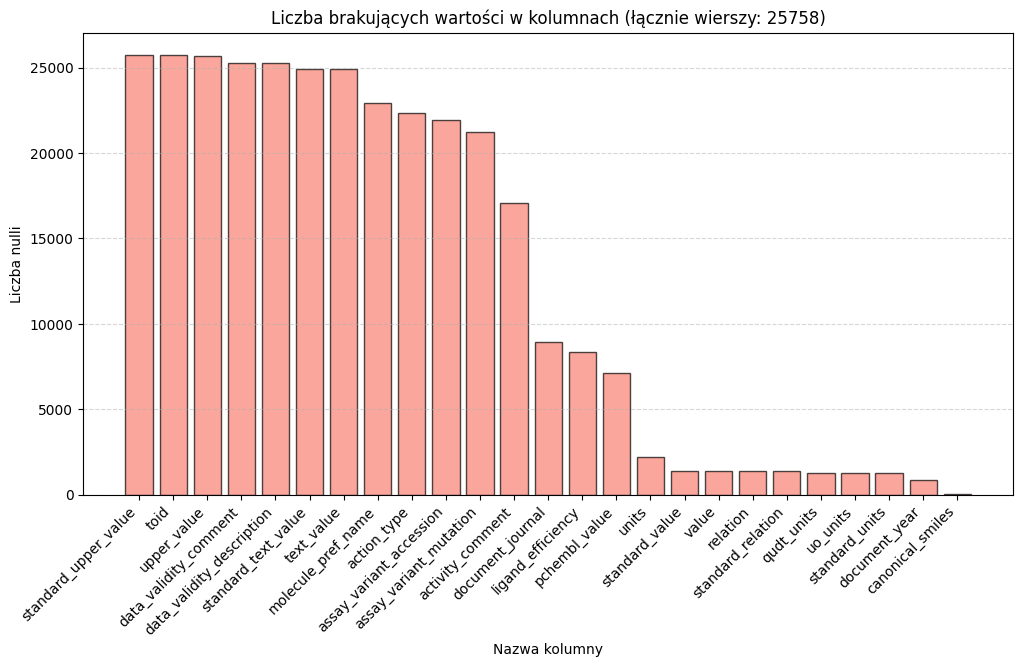

In [24]:
# Sprawdzanie nulli
nulls = df_activity.null_count().to_dicts()[0]


filtered_nulls = {k: v for k, v in nulls.items() if v > 0}
sorted_nulls = dict(sorted(filtered_nulls.items(), key=lambda item: item[1], reverse=True))

columns = list(sorted_nulls.keys())
counts = list(sorted_nulls.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(columns, counts, color='salmon', edgecolor='black', alpha=0.7)

plt.title(f'Liczba brakujących wartości w kolumnach (łącznie wierszy: {len(df_activity)})')
plt.xlabel('Nazwa kolumny')
plt.ylabel('Liczba nulli')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

print("Dane na temat nulli w kolumnach:")
print(df_activity.null_count())
plt.show()

In [4]:
# 1. Konwersja typów i wstępne czyszczenie
df_clean = (
    df_activity.unique(subset=["record_id"], keep="first")
    .with_columns(
        pl.col("pchembl_value").cast(pl.Float64, strict=False)
    )
    .filter(
        (pl.col("standard_value").is_not_null()) &
        (pl.col("canonical_smiles").is_not_null()) &
        (pl.col("standard_relation") == "=") &
        (pl.col("standard_units") == "nM")
    )
)

print(f"Liczba wierszy przed czyszczeniem: {len(df_activity)}")
print(f"Liczba wierszy po czyszczeniu: {len(df_clean)}")

df_unique = (
    df_clean
    .group_by("molecule_chembl_id")
    .agg([
        pl.col("pchembl_value").mean().alias("mean_pchembl"),
        pl.col("standard_value").mean().alias("mean_standard_value"),
        pl.col("canonical_smiles").first() # Bierzemy pierwszy SMILES
    ])
)

print(f"Liczba unikalnych cząsteczek: {len(df_unique)}")

Liczba wierszy przed czyszczeniem: 25758
Liczba wierszy po czyszczeniu: 12634
Liczba unikalnych cząsteczek: 10254


In [5]:
# 2. Sprawdzenie duplikatów (jedna cząsteczka mogła być badana wielokrotnie)
# Grupujemy po ID cząsteczki i liczymy średnią z pchembl_value i standard_value
df_unique = (
    df_clean
    .group_by("molecule_chembl_id")
    .agg([
        pl.col("pchembl_value").mean().alias("mean_pchembl"),
        pl.col("standard_value").mean().alias("mean_standard_value"),
        pl.col("canonical_smiles").first() # Bierzemy pierwszy SMILES
    ])
)

print(f"Liczba unikalnych cząsteczek: {len(df_unique)}")

Liczba unikalnych cząsteczek: 10254


Wykresy zostały wygenerowane.


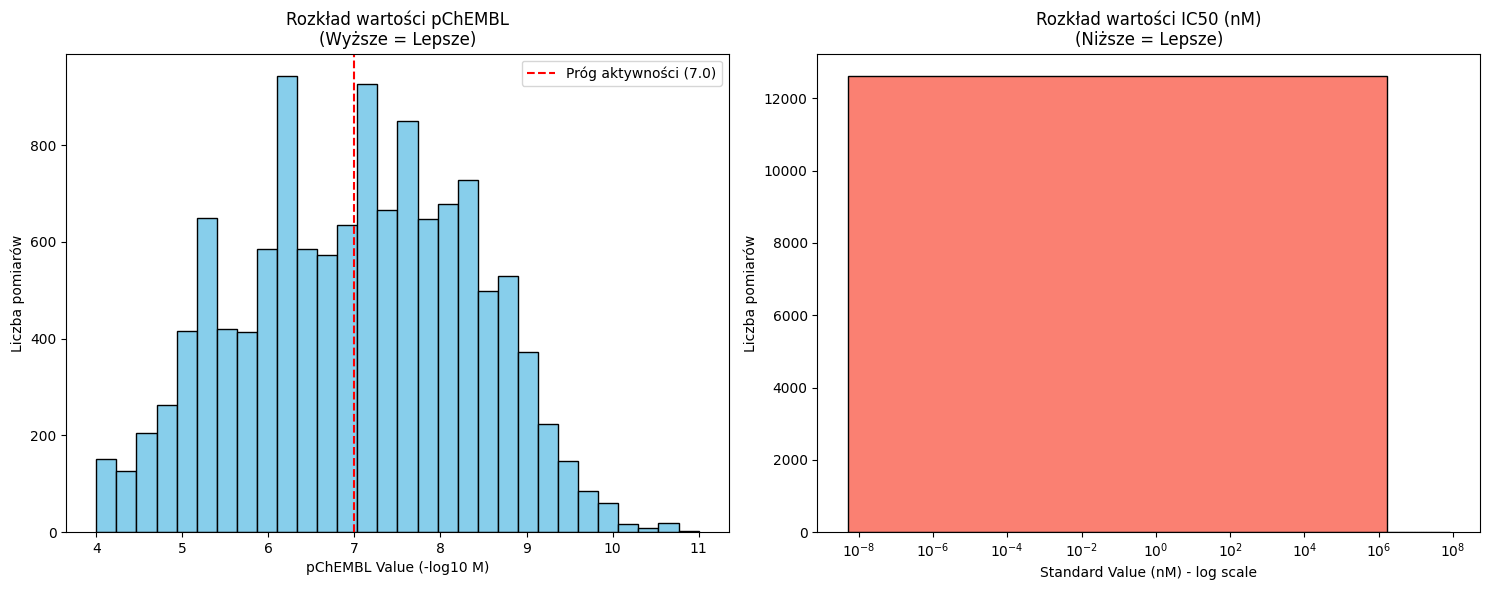

In [6]:
# Przygotowanie danych do wykresu (Polars -> Numpy/List)
pchembl_vals = df_clean["pchembl_value"].drop_nulls().to_list()
std_vals = df_clean["standard_value"].drop_nulls().to_list()

# Tworzenie wykresów
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Wykres 1: Rozkład pChEMBL (skala logarytmiczna aktywności)
# Wartości > 6-7 są zazwyczaj uważane za aktywne, > 9 za bardzo silne
ax[0].hist(pchembl_vals, bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Rozkład wartości pChEMBL\n(Wyższe = Lepsze)')
ax[0].set_xlabel('pChEMBL Value (-log10 M)')
ax[0].set_ylabel('Liczba pomiarów')
ax[0].axvline(x=7, color='red', linestyle='--', label='Próg aktywności (7.0)')
ax[0].legend()

# Wykres 2: Rozkład Standard Value (IC50 w nM) - Skala logarytmiczna na osi X
# Tutaj niższe wartości są lepsze (potrzeba mniej leku, by zachamować cel)
ax[1].hist(std_vals, bins=50, color='salmon', edgecolor='black')
ax[1].set_xscale('log') # Kluczowe dla stężeń!
ax[1].set_title('Rozkład wartości IC50 (nM)\n(Niższe = Lepsze)')
ax[1].set_xlabel('Standard Value (nM) - log scale')
ax[1].set_ylabel('Liczba pomiarów')

plt.tight_layout()
print("Wykresy zostały wygenerowane.")
plt.show() # Odkomentuj jeśli używasz Jupyter Notebook

Liczba punktów danych (surowe): 18650


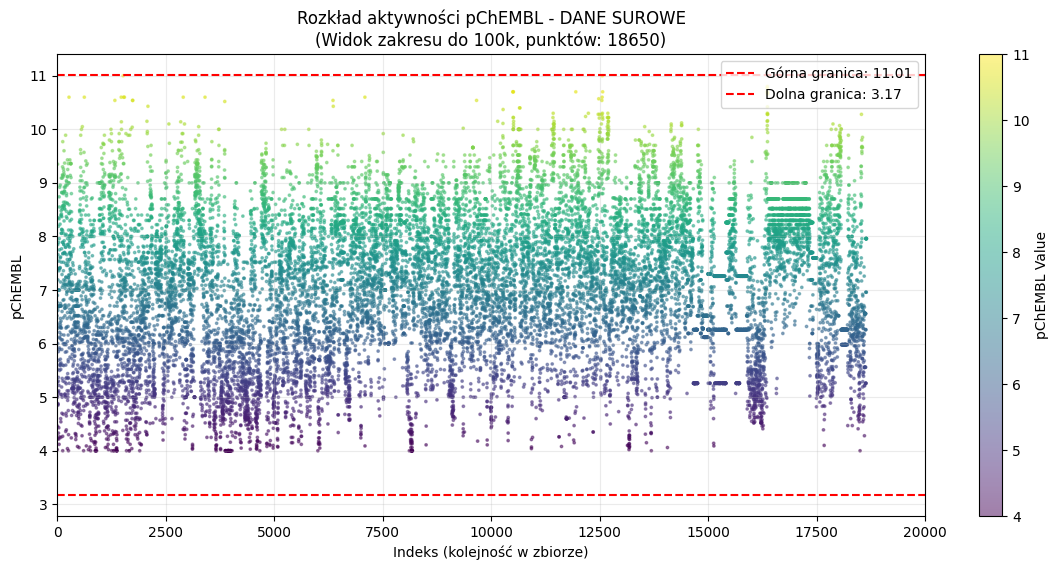

In [19]:
# 1. Przygotowanie danych z surowej ramki df_activity
# Rzutujemy na float (w surowych danych mogą być stringi) i usuwamy nulle
df_raw_plot = (
    df_activity
    .select("pchembl_value")
    .with_columns(pl.col("pchembl_value").cast(pl.Float64, strict=False))
    .drop_nulls()
)

values_raw = df_raw_plot["pchembl_value"].to_numpy()
num_points_raw = len(values_raw)
indices_raw = np.arange(num_points_raw)

print(f"Liczba punktów danych (surowe): {num_points_raw}")

# 2. Obliczenie statystyk do linii
q1 = np.percentile(values_raw, 25)
q3 = np.percentile(values_raw, 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

plt.figure(figsize=(14, 6))

# 3. Rysowanie
# Używamy mniejszego 's' i alpha, bo punktów jest dużo i mogą się nakładać
sc = plt.scatter(indices_raw, values_raw, c=values_raw, cmap='viridis', 
                 s=3, alpha=0.5, rasterized=True) 

# Linie referencyjne
plt.axhline(y=upper_bound, color='red', linestyle='--', label=f'Górna granica: {upper_bound:.2f}')
plt.axhline(y=lower_bound, color='red', linestyle='--', label=f'Dolna granica: {lower_bound:.2f}')

# 4. Ustawienie sztywnego zakresu osi X do 100 000
plt.xlim(0, 20000)

plt.colorbar(sc, label='pChEMBL Value')
plt.title(f'Rozkład aktywności pChEMBL - DANE SUROWE\n(Widok zakresu do 100k, punktów: {num_points_raw})', fontsize=12)
plt.xlabel('Indeks (kolejność w zbiorze)')
plt.ylabel('pChEMBL')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.25)

plt.show()

Liczba rzeczywistych punktów danych: 10141


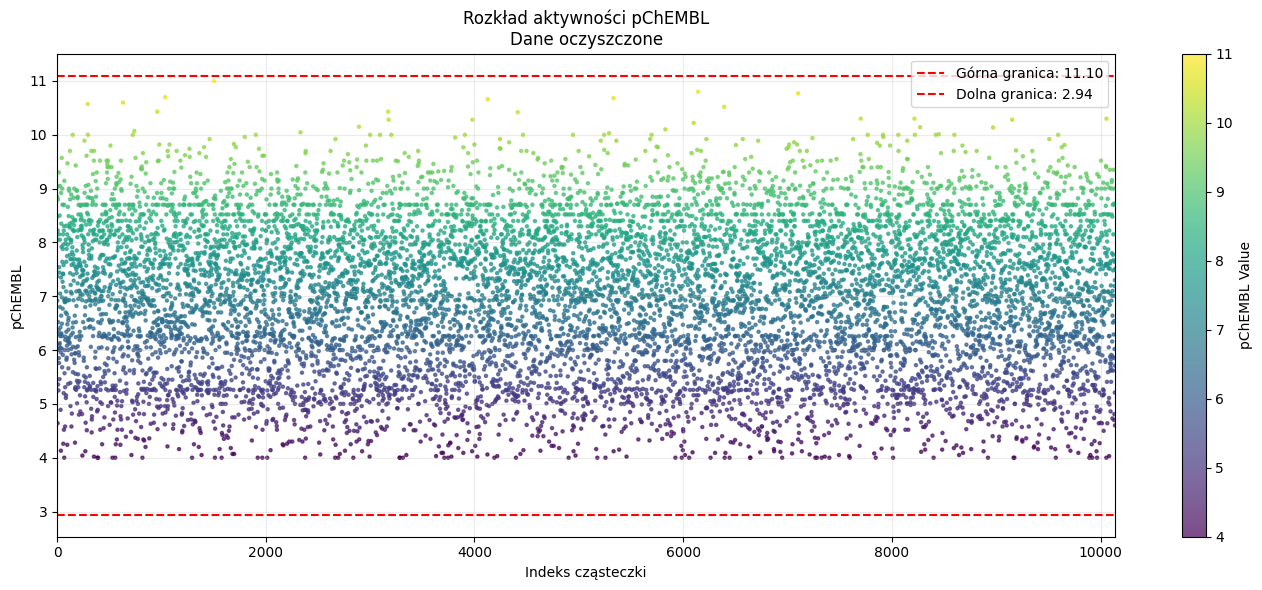

In [20]:
# Sprawdzenie czy dane istnieją
if "df_unique" not in locals():
    print("Brak danych. Uruchom najpierw komórki przetwarzające df_unique.")
else:
    # Pobranie danych
    values = df_unique["mean_pchembl"].drop_nulls().to_numpy()
    num_points = len(values)
    indices = np.arange(num_points)
    
    print(f"Liczba rzeczywistych punktów danych: {num_points}")

    # Statystyki do linii referencyjnych
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    plt.figure(figsize=(14, 6))

    # Rysowanie punktów
    # Zwiększamy nieco 's' (rozmiar punktu), żeby były lepiej widoczne
    sc = plt.scatter(indices, values, c=values, cmap='viridis', 
                     s=5, alpha=0.7, rasterized=True) 

    # Linie granicze
    plt.axhline(y=upper_bound, color='red', linestyle='--', label=f'Górna granica: {upper_bound:.2f}')
    plt.axhline(y=lower_bound, color='red', linestyle='--', label=f'Dolna granica: {lower_bound:.2f}')

    # --- KLUCZOWE USTAWIENIE OSI ---
    # Ustawiamy limit na 100 000 (lub więcej, jeśli mamy więcej danych)
    # To gwarantuje, że oś X zawsze pokaże zakres co najmniej 0-100k
    x_limit = max(10000, num_points)
    plt.xlim(0, x_limit)

    plt.colorbar(sc, label='pChEMBL Value')
    
    # Tytuł wyjaśniający co widać
    plt.title(f'Rozkład aktywności pChEMBL\nDane oczyszczone', fontsize=12)
    
    plt.xlabel('Indeks cząsteczki')
    plt.ylabel('pChEMBL')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.25) # Dodanie siatki dla lepszej orientacji

    plt.tight_layout()
    plt.show()

In [9]:
# Funkcja pomocnicza do obliczania deskryptorów
def calculate_lipinski_props(df):
    data_props = []
    
    # Iterujemy po danych (ID i SMILES)
    # Używamy iter_rows dla prostoty, przy 10k cząsteczek to potrwa kilka sekund
    for row in df.select(["molecule_chembl_id", "canonical_smiles"]).iter_rows(named=True):
        smi = row["canonical_smiles"]
        mid = row["molecule_chembl_id"]
        
        if smi:
            try:
                mol = Chem.MolFromSmiles(smi)
                if mol:
                    data_props.append({
                        "molecule_chembl_id": mid,
                        "MW": Descriptors.MolWt(mol),
                        "LogP": Descriptors.MolLogP(mol),
                        "HBD": Descriptors.NumHDonors(mol),
                        "HBA": Descriptors.NumHAcceptors(mol)
                    })
            except:
                continue # Pomijamy błędy parsowania

    return pl.DataFrame(data_props)

print("Rozpoczynam obliczanie właściwości fizykochemicznych...")
df_props = calculate_lipinski_props(df_unique)

# Łączymy wyniki z naszą główną tabelą df_unique
df_analysis = df_unique.join(df_props, on="molecule_chembl_id", how="inner")

print(f"Gotowe! Obliczono właściwości dla {len(df_analysis)} cząsteczek.")
print(df_analysis.head(3))

Rozpoczynam obliczanie właściwości fizykochemicznych...


Gotowe! Obliczono właściwości dla 10254 cząsteczek.
shape: (3, 8)
┌────────────────────┬──────────────┬─────────────────────┬─────────────────────────────────┬─────────┬─────────┬─────┬─────┐
│ molecule_chembl_id ┆ mean_pchembl ┆ mean_standard_value ┆ canonical_smiles                ┆ MW      ┆ LogP    ┆ HBD ┆ HBA │
│ ---                ┆ ---          ┆ ---                 ┆ ---                             ┆ ---     ┆ ---     ┆ --- ┆ --- │
│ str                ┆ f64          ┆ f64                 ┆ str                             ┆ f64     ┆ f64     ┆ i64 ┆ i64 │
╞════════════════════╪══════════════╪═════════════════════╪═════════════════════════════════╪═════════╪═════════╪═════╪═════╡
│ CHEMBL384711       ┆ 7.37         ┆ 43.0                ┆ CS(=O)(=O)CCNCc1ccc(-c2ccc3ncn… ┆ 607.53  ┆ 6.1091  ┆ 2   ┆ 8   │
│ CHEMBL598306       ┆ 6.0          ┆ 1010.0              ┆ CCCCCCCCCCCCCCOC(=O)COc1cc(O)c… ┆ 508.655 ┆ 7.7887  ┆ 1   ┆ 6   │
│ CHEMBL294213       ┆ null         ┆ 2.2e6         

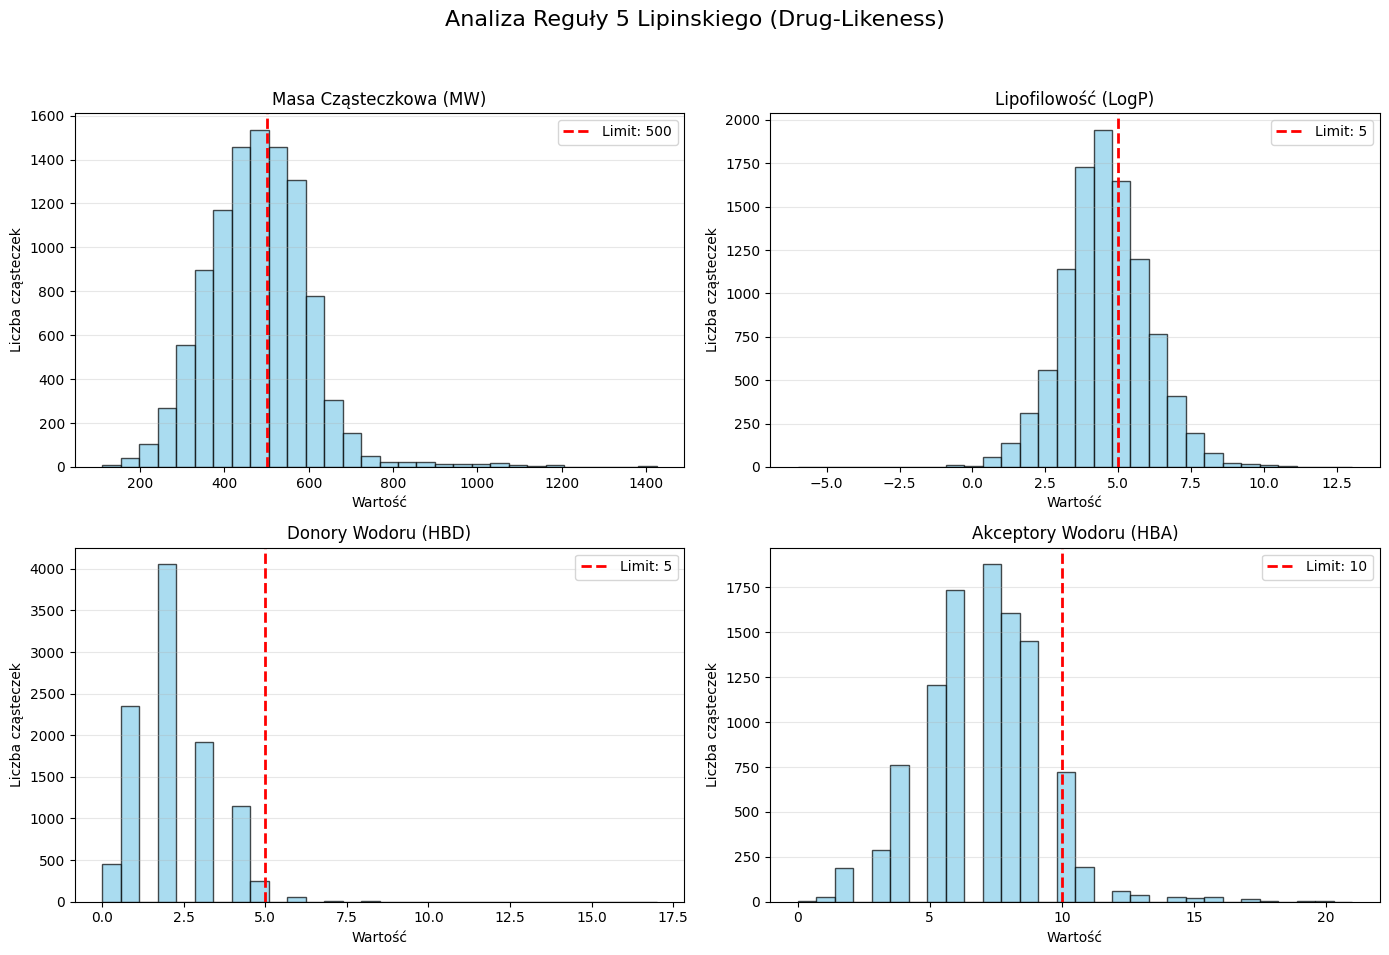

In [10]:
# Konwersja do pandas/numpy dla łatwiejszego rysowania
data_viz = df_analysis.select(["MW", "LogP", "HBD", "HBA"]).to_pandas()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Analiza Reguły 5 Lipinskiego (Drug-Likeness)', fontsize=16)

# Parametry wykresów (Kolumna, Tytuł, Limit Lipinskiego)
params = [
    ("MW", "Masa Cząsteczkowa (MW)", 500),
    ("LogP", "Lipofilowość (LogP)", 5),
    ("HBD", "Donory Wodoru (HBD)", 5),
    ("HBA", "Akceptory Wodoru (HBA)", 10)
]

# Pętla rysująca 4 histogramy
for ax, (col, title, limit) in zip(axs.flat, params):
    ax.hist(data_viz[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(limit, color='red', linestyle='--', linewidth=2, label=f'Limit: {limit}')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Wartość')
    ax.set_ylabel('Liczba cząsteczek')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()